# Figure 4: Hail function comparison

Above, the hail function for the best performing model as determined by the ELPD. Below, the distribution of the value of MESH at which severe hail becomes more likely than not with the different prior perturbations. The dashed line indicates a 30 mm MESH threshold. References to strength in the prior names refer to informativeness of the prior (e.g. weakly informative, strongly informative, etc.).

## Package imports

In [12]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(posterior, lib.loc = additional_package_lib)
  library(ggridges, lib.loc = additional_package_lib)
  library(scico)
  library(patchwork)
  library(janitor, lib.loc = additional_package_lib)
})

## Utility functions

In [13]:
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

yeo_johnson <- function(x, lambda) {
  # Yeo-Johnson transform of x using parameter lambda
  #
  # Inputs:
  #  x       numeric
  #          the numeric (vector) to be transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
    
  eps <- 1e-5
  if (x >= 0.0){
    if (abs(lambda) < eps){
      log1p(x)
    } else {
      (((x + 1.0) ^ lambda) - 1.0) / lambda
    }
  } else {
    if (abs(lambda - 2.0) < eps) {
      -log1p(-x)
    } else {
      -(((-x + 1.0) ^ (2.0 - lambda)) - 1.0) / (2.0 - lambda)
    }
  }
}

inv_yeo_johnson <- function(x, lambda){
  # Inverse Yeo-Johnson transform of x using parameter lambda
  #
  # Inputs:
  #  x       numeric
  #          the numeric (vector) to be invrse transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
  eps <- 1e-5
  if (x >= 0){
    if (abs(lambda) < eps) {
      exp(x) - 1
    } else {
      ((x * lambda + 1.0) ^ (1.0 / lambda)) - 1.0
    }
  } else {
    if (abs(lambda - 2.0) < eps) {
      1.0 - exp(-x)
    } else {
      1.0 - ((x * (lambda - 2.0) + 1.0) ^ (1.0 / (2.0 - lambda)))
    }
  }
}

In [14]:
get_prob_hail_at_mesh <- function(model_name, prob = 0.5){
  # Invert the hail function to calculate the probaility of hail at a given MESH value.
  #
  # Inputs:
  #  model_name    str
  #                the name of the model in question, to read in correct parameters
  #  prob          float, default 0.5
  #                the probability of interest
  #
  # Outputs:
  #  untrans_mesh  vector
  #                samples of MESH values at which the probability of hail is equal to
  #                given prob
    
  # read in all parameters
  all_params <- readRDS(paste(base_dir, model_name, "results", paste(model_name, "model_params_full.rds", sep = "_"), sep = "/"))

  # create beta hail
  suppressWarnings({
    beta_hail <- all_params %>%
      as_draws_df() %>%
      select(starts_with("beta_hail")) %>%
      select(-contains("raw")) %>%
      as.matrix()
  })

  # getting the transformed MESH value
  trans_mesh <- map_dbl(1:nrow(beta_hail), \(x) (log(prob / (1 - prob)) - beta_hail[x, 1]) / beta_hail[x, 2]) 

  if(str_detect(model_name, "trans")){
    # pre-allocate
  untrans_mesh <- map_dbl(1:nrow(beta_hail), \(x) inv_yeo_johnson(trans_mesh[x], beta_hail[x, 3]))
  } else {
    #  using inverse relationship
    untrans_mesh <- trans_mesh ^ 2
  }
  untrans_mesh
}

Note that in the `.stan` files we calculate both the coefficients relating to YJ* but also those of that relate to the unstandardised YJ transform so that we do not need to calculate the mean and standard deviation of transformed MESH here and in other similar places.

In [15]:
make_plot_of_mesh_at_given_prob <- function(){
  # Make a ridge plot of the distribution of MESH at which the probability of hail is
  # 0.5. Labels the plot accordingly.
  # 
  # Inputs:
  #   none
  # 
  # Outputs:
  #   _     ggplot object
  #         the labeled ridges plot
    
  # get a list of the distribution of MESH in each model 
  mesh_at_0p5 <- map(model_names, get_prob_hail_at_mesh) # 0.5 is default
  # label with model names
  names(mesh_at_0p5) <- model_names
  
  # list to tibble
  bind_rows(mesh_at_0p5, .id = "model_names") %>%
  # pivot longer for plotting
  pivot_longer(everything()) %>%
  # clean lables of 
  mutate(mesh_trans = case_when(str_detect(name, "hail_std_sqrt_mesh") ~ "Square root", # for models using sqrt
                                                                                        # not YJ for MESH
                                str_detect(name, "hail_trans_std_mesh") ~ "Yeo-Johnson",
                                TRUE ~ "None"),                                         # for models using no 
                                                                                        # MESH transform
         dens_trans = case_when(str_detect(name, "report_std_nolog_dens") ~ "None",     # for models using no
                                                                                        # pop dens transform
                                str_detect(name, "report_trans_std_dens") ~ "Yeo-Johnson",
                                TRUE ~ "Logarithmic"),                                  # for models using 
                                                                                        # log pop dens
         yj_prior = case_when(str_detect(name, "yjwide") ~ "Very weak",
                              str_detect(name, "yjnarrow") ~ "Strong",
                              str_detect(name, "trans") ~ "Weak",
                              TRUE ~ "NA"),
         prior = case_when(str_detect(name, "_wide") ~ "Very weak normal",
                              str_detect(name, "_narrow") ~ "Strong normal",
                              str_detect(name, "negative") ~ "Negative translation",
                              str_detect(name, "positive") ~ "Positive translation",
                              str_detect(name, "gamma") ~ "Gamma",
                              str_detect(name, "lognormal") ~ "Log-normal",
                              str_detect(name, "filter_numevents_probhail") ~ "Filter num. events and prob. hail",
                              str_detect(name, "filter_numevents") ~ "Filter num. events",
                              str_detect(name, "filter_probhail") ~ "Filter prob. hail",
                              TRUE ~ "Weak normal")) %>%
  # plotting
  ggplot(aes(x = value, y = prior)) + 
  geom_density_ridges(aes(color = yj_prior), fill = NA, rel_min_height = 0.003, scale = 0.95) +
  # labels
  xlab("MESH at P(Hail = 1 | MESH) = 0.5") +
  ylab("Prior regime") +
  labs(color = "Yeo-Johnson\nPrior") +
  # size
  theme_gray(base_size = 18)
}

In [16]:
function_quantiles_from_draws <- function(x_matrix, par_matrix, name){
  # (simplified) function which, given a matrix at which to evaluate the probability,
  # will employ the given simulation draws to calculate quantiles of said
  # probability at each evaluation point. 
  # 
  # Inputs:
  #  x_matrix      matrix (neval x npars)
  #                each row representats a point at which to evaluate
  #                the probability and calculate its statistics
  #  par_matrix    matrix (ndraws x npars)
  #                contains draws of the parameters from stan
  #  name          str
  #                used to name the columns of the resulting tibble
  #
  # Outputs:
  #  _             tibble (neval x 8)
  #                each row corresponds to a row in x_matrix with columns
  #                corresponding to statistics (e.g. <name>_2_5_percent, ...)
  
  # create mat_func: matrix with probability at each x location (row) for 
  # the number of simulations (col)
  
  # assumes 3rd element of beta used to transform second element of x
  # written for mesh but works equally well for population density
  
  # pre-allocate matrix for the raw multiplication results
  raw_mult <- matrix(0, nrow = nrow(x_matrix), ncol = nrow(par_matrix))
  # fill matrix by column
  for (j in 1:ncol(raw_mult)) {
    # transform mesh (second column) using jth parameter in third column
    mesh_trans <- map_dbl(x_matrix[, 2], \(x) yeo_johnson(x, par_matrix[j, 3]))
    # create new matrix with this second column 
    if (ncol(x_matrix) == 2) {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans)
    } else {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans, x_matrix[, 3:ncol(x_matrix)])
    }
    # doing the matrix multiplication to get that one column
    # should need transpose but R does it itself for a vector
    raw_mult[, j] <- mesh_trans_matrix %*% par_matrix[j, -3] 
  }
  # inverse logit transform of the matrix to get probabilities 
  mat_func <- inv_logit(raw_mult)
    
  # using apply to take quantiles over matrix
  apply(mat_func, MARGIN = 1, FUN = quantile, 
    # note changed probs
    probs = c(0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995)) %>%
    t() %>%
    # adding row means 
    cbind(mean = rowMeans(mat_func)) %>% 
    # converting to tibble
    as_tibble(.name_repair = "unique") %>% 
    # rename: <NAME>_2_5_percent, <NAME>_5_percent, etc.
    rename_with(~ paste(name, gsub("x", "", make_clean_names(.x)), sep = "_"))
}

## Constants

In [17]:
# model names to be included in the panel figure
model_names <- c("hail_trans_std_mesh_report_trans_std_dens",
                 "hail_trans_std_mesh_report_trans_std_dens_wide",
                 "hail_trans_std_mesh_report_trans_std_dens_narrow",
                 "hail_trans_std_mesh_report_trans_std_dens_positive",
                 "hail_trans_std_mesh_report_trans_std_dens_negative",
                 "hail_trans_std_mesh_report_trans_std_dens_gamma",
                 "hail_trans_std_mesh_report_trans_std_dens_lognormal",
                 "hail_trans_std_mesh_report_trans_std_dens_filter_numevents",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_wide",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_narrow",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_positive",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_negative",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_gamma",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_lognormal",
                 "hail_trans_std_mesh_report_trans_std_dens_yjwide_filter_numevents",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_wide",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_narrow",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_positive",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_negative",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_gamma",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_lognormal",
                 "hail_trans_std_mesh_report_trans_std_dens_yjnarrow_filter_numevents"
)

# base directory for all the data
base_dir <- "/g/data/w42/ig1052/bayesian_paper_data/model_eval"

## Read in data

In [18]:
# model data: report is factor
model_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_",
                              "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                              "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_",
                              "-26.50_0.25.csv"),
                      col_types = "nnTnnnnnnncnffffff")

Need the best model to plot the actual hail function.

In [19]:
# combine with hail probability 
model_to_use <- "hail_trans_std_mesh_report_trans_std_dens_yjwide_gamma"
model_params <- readRDS(paste(base_dir, model_to_use, "results", 
                              paste0(model_to_use, "_model_params_full.rds"), sep = "/"))

# get x-matrix for plotting 
x_matrix <- cbind(1, seq(min(model_data$mesh), max(model_data$mesh), length.out = 100))
suppressWarnings({
  par_matrix <- model_params[, , c("beta_hail[1]", "beta_hail[2]", "beta_hail[3]")] %>% 
    as_draws_df %>%
    select(starts_with("beta")) %>% # generates a warning as we are only selecting some variables
    as.matrix
})

function_quantiles <- function_quantiles_from_draws(x_matrix = x_matrix, par_matrix = par_matrix, 
                                                    name = "hail")

## Make plot

In [20]:
# the ridges plot using all the models
p1 <- make_plot_of_mesh_at_given_prob() +
  # fixing colour scheme
  scale_color_manual(values = scico(3, begin = 0.2, end = 0.8, palette = "batlow")) +
  # marking common MESH threhsold
  geom_vline(aes(xintercept = 30), linetype = "dashed")

In [21]:
# making the plot of the hila function for hte best model
fill_colour <- scico(1, begin = 0.2, end = 0.8, palette = "batlow")
p2 <- function_quantiles %>%
  add_column(mesh = x_matrix[, 2]) %>%
  ggplot(aes(x = mesh)) + 
  geom_line(aes(y = hail_mean)) +
  geom_ribbon(aes(ymin = hail_0_5_percent, ymax = hail_99_5_percent, alpha = "99%"), fill = fill_colour) + # 0.1
  geom_ribbon(aes(ymin = hail_2_5_percent, ymax = hail_97_5_percent, alpha = "95%"), fill = fill_colour) + # 0.3
  geom_ribbon(aes(ymin = hail_25_percent, ymax = hail_75_percent, alpha = "50%"), fill = fill_colour) + # 0.8
  scale_alpha_manual(values = c(0.8, 0.3, 0.1)) +
  labs(alpha = "Credible\ninterval") +
  theme_gray(base_size = 18) +
  xlab("MESH [mm]") + 
  ylab("Posterior P(Hail = 1 | MESH)")

Picking joint bandwidth of 1.64



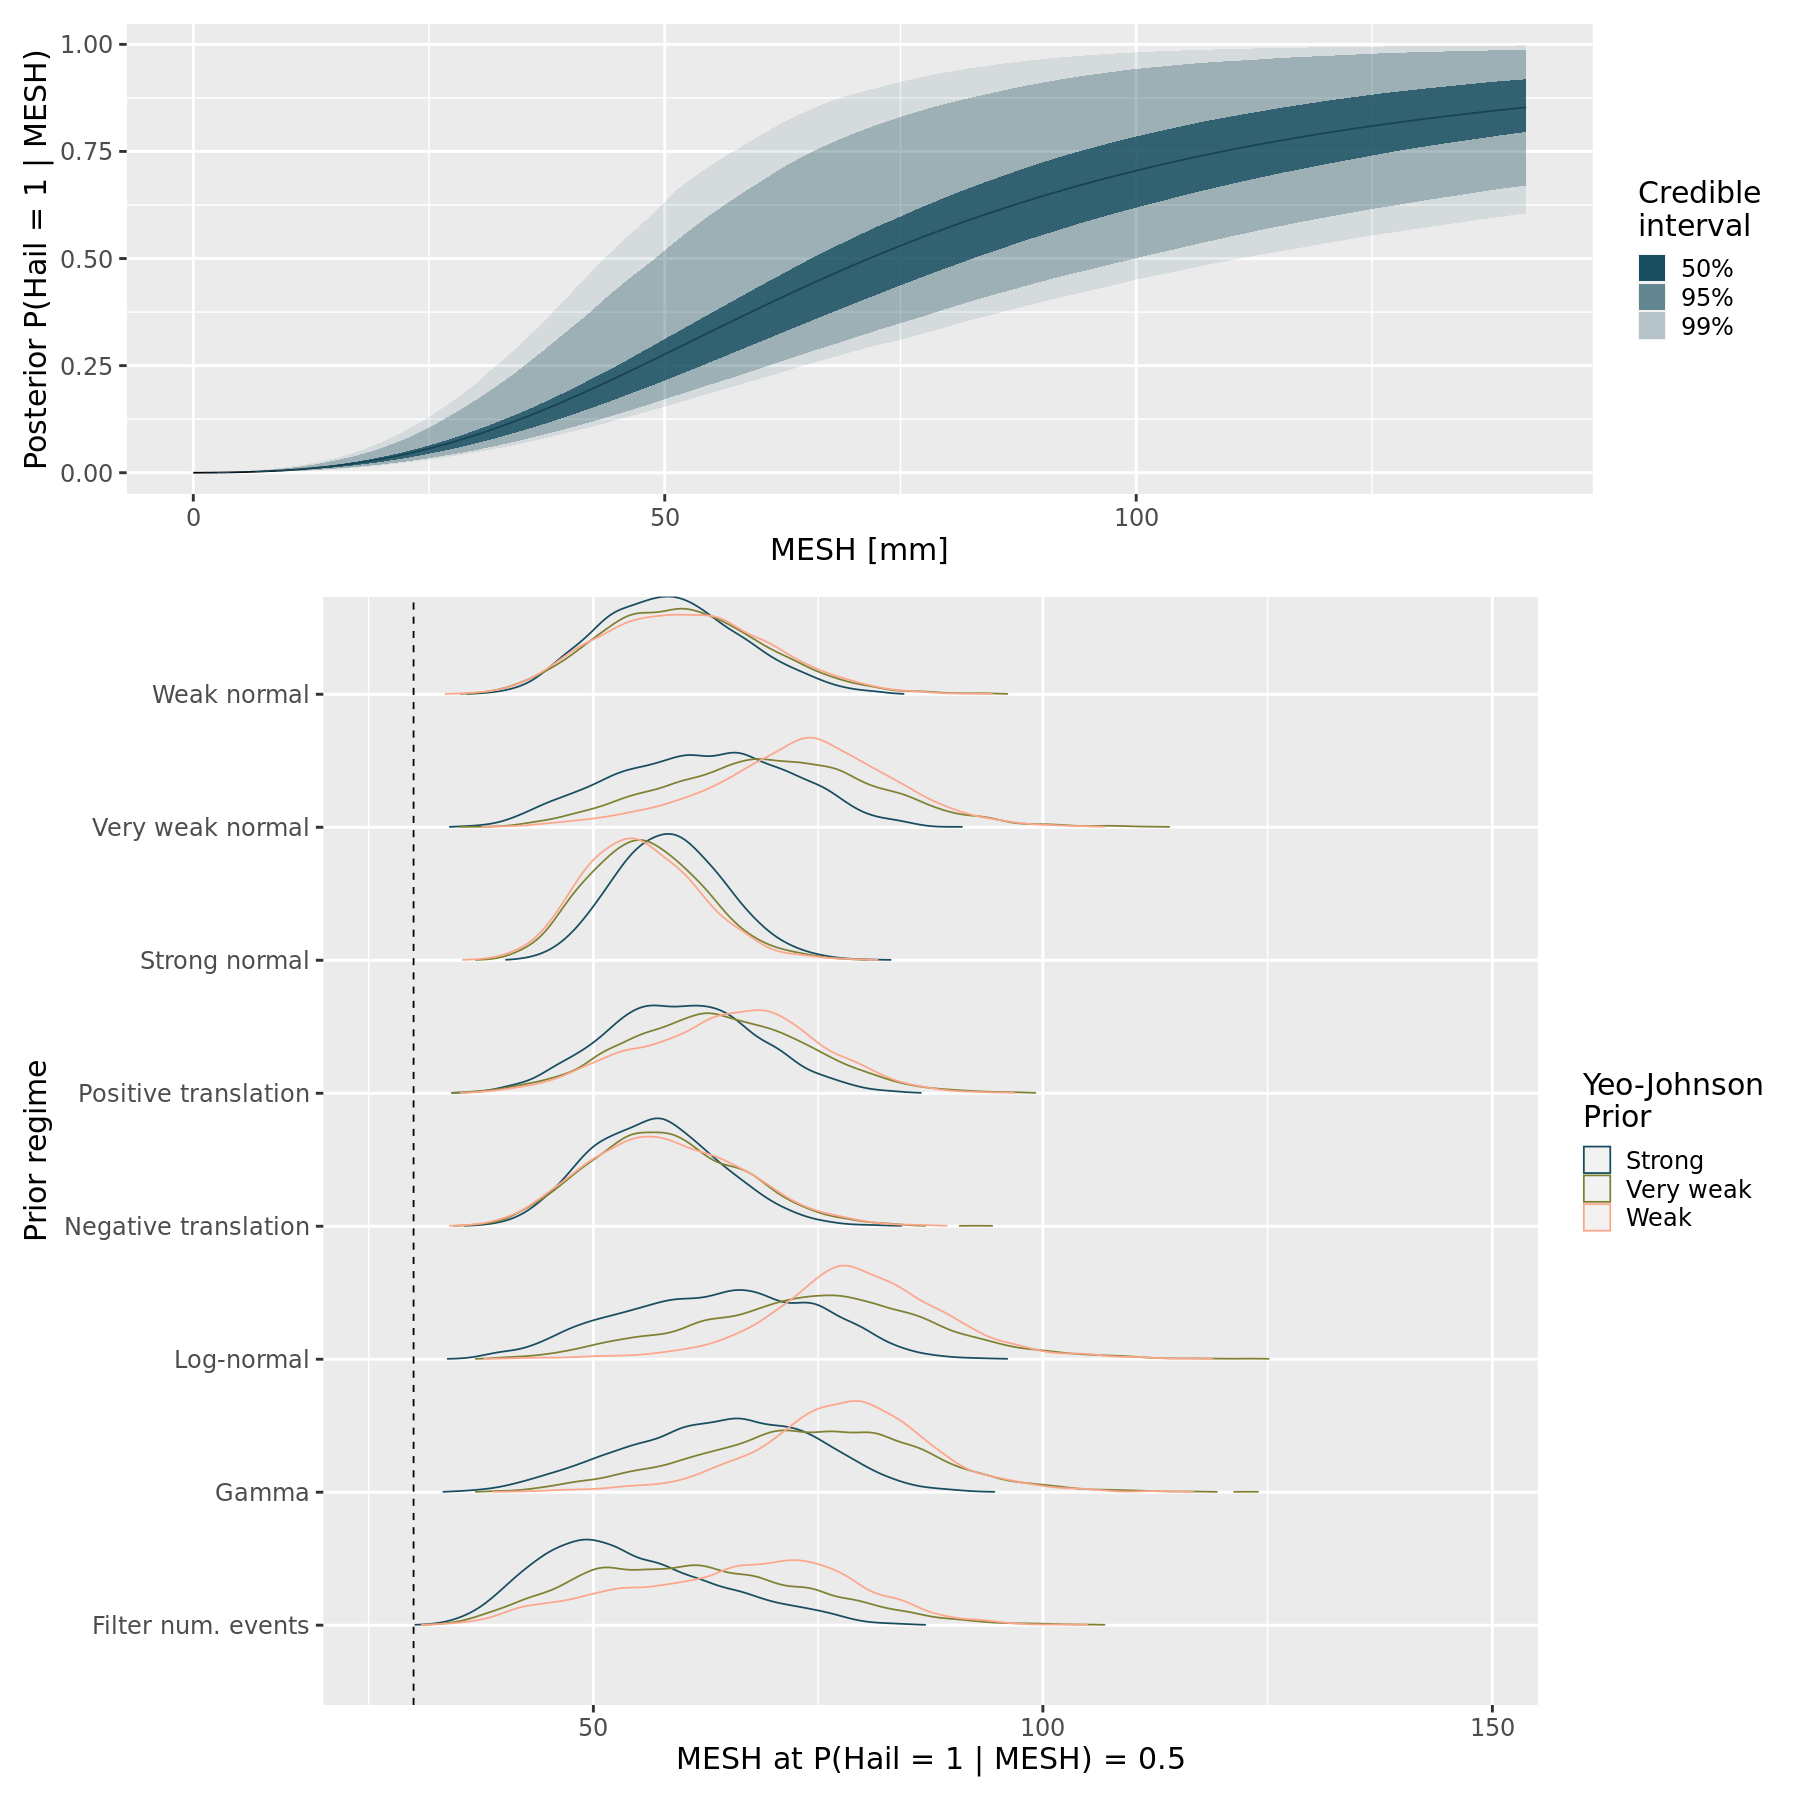

In [22]:
# viewing size 
options(repr.plot.width = 15, repr.plot.height = 15)

# displaying plots together
wrap_elements(full = p2) / p1 + 
  plot_layout(height = c(1, 2)) #+ 
#  plot_annotation(tag_levels = 'a', tag_prefix = "(", tag_suffix = ")")